## Deep Learning Autoencoders for Reducing PAPR in Coherent Optical Systems

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import special
from scipy.signal import spectrogram
from scipy.signal import welch
import math
import os
import time
import sys
import glob

from commpy.utilities import upsample
from optic.dsp.core import pnorm, pulseShape, signal_power, movingAverage
from optic.dsp.carrierRecovery import cpr
from optic.models.devices import iqm, phaseNoise, coherentReceiver, edfa, basicLaserModel
from optic.models.channels import ssfm, manakovSSF, awgn
from optic.comm.modulation import GrayMapping, modulateGray
from optic.utils import parameters
from optic.plot import plotPSD, pconst
from optic.comm.ofdm  import modulateOFDM, demodulateOFDM
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, Concatenate, BatchNormalization, ReLU, Flatten, Add
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
import keras.backend as K
from keras.utils import plot_model

%matplotlib inline
import mpld3

from heapq import nsmallest
import cmath

## defining funcitons ##############

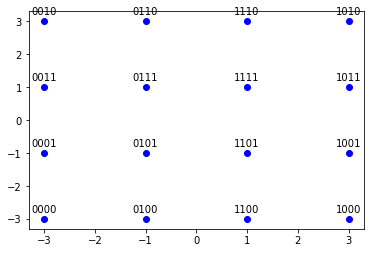

In [6]:
# QAM Mapping Table

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

# The demapping table is simply the inverse mapping of the mapping table:

# %%
demapping_table = {v : k for k, v in mapping_table.items()}

def OFDM_symbol(QAM_payload):
    symbol = np.zeros( (QAM_payload.shape[0], 1024), dtype=complex )
#     symbol = np.zeros( (QAM_payload.shape[0], 1024), dtype=complex )
    symbol[:,0] = 60 + 1j*60 # allocate the RF pilot subcarriers
    symbol[:,11+10:449] = QAM_payload[:,0:438-10]  # allocate the Data1 subcarriers
    symbol[:,577:1014-10] = QAM_payload[:,438-10:875-20]  # allocate the Data2 subcarriers
    return symbol

def OFDM_symbol_Rx(QAM_rx):
    QAM_payload_rx = np.zeros( (QAM_rx.shape[0], 855), dtype=complex )
    QAM_payload_rx[:,0:428] = QAM_rx[:,11+10:449]
    QAM_payload_rx[:,428:855] = QAM_rx[:,577:1014-10]
    return QAM_payload_rx

def addCP(OFDM_time):
    return np.concatenate([OFDM_time[:, (1024-128) : ], OFDM_time], axis=-1)  # ... and add last CP them to the beginning

def removeCP(signal):
    return signal[:, 128: ]

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def PS(bits):
    return bits.reshape((-1,))

def rfp(OFDM_freq_domain, OFDM_time_domain):
    # Filter out RF + guide band
    OFDM_freq_domain[:, 11+10:1014-10] = 0

    # Convert back to time domain
    OFDM_ifft_freq = np.fft.ifft(OFDM_freq_domain, 1024)

    # Extract the phase
#     phase_exp = OFDM_ifft_freq/np.abs(OFDM_ifft_freq)
    rfp_angle = np.angle(OFDM_ifft_freq)

    # compensation in time domain 
#     OFDM_time_domain_comp = OFDM_time_domain*np.conj(phase_exp)
    OFDM_time_domain_comp = OFDM_time_domain*np.exp(-1j*rfp_angle)
    
    # returen frequency domain data
    return np.fft.fft(OFDM_time_domain_comp, 1024)

def ce(OFDM_rec_freq, OFDM_tx_freq, OFDM_tx_freq_orig):
    # this function is independent from number of subcarriers
    combined_matrix = None
    combined_matrix_tx = None
    combined_matrix_tx_orig = None
  
    for i in range(0, len(OFDM_rec_freq), 52):
        # Get the chunk of 50 rows
        chunk = OFDM_rec_freq[i:i+52, :]
        chunk_tx = OFDM_tx_freq[i:i+52, :]
        chunk_tx_orig = OFDM_tx_freq_orig[i:i+52, :]
        
        # Estimate the Ch. Effect from first 4 rows (OFDM symbols)
        
        ch_diff = chunk[:4]/chunk_tx[:4]
        
        # Calculate the sum of the first 4 rows elementwise and take the average
        avg_sum = np.mean(ch_diff[:4], axis=0)
        
        # Divide the result by the rest of the rows (from 5 to 52)
        rest_rows = chunk[4:]
        rest_rows_tx = chunk_tx[4:]
        rest_rows_tx_orig = chunk_tx_orig[4:]
        
        if combined_matrix is None:
            combined_matrix = rest_rows / avg_sum.T
            combined_matrix_tx = rest_rows_tx
            combined_matrix_tx_orig = rest_rows_tx_orig
        else:
            combined_matrix = np.concatenate((combined_matrix, rest_rows / avg_sum.T), axis=0)
            combined_matrix_tx = np.concatenate((combined_matrix_tx, rest_rows_tx), axis=0)
            combined_matrix_tx_orig = np.concatenate((combined_matrix_tx_orig, rest_rows_tx_orig), axis=0)
                
    return combined_matrix, combined_matrix_tx_orig


def opt_domain(input_el):

    Rs  = 2.5e9         # symbol rate [baud]
    SpS = 2           # samples per symbol

    ################ Optical Modulation #######################################
    # transmitter parameters
    Ts = 1 / Rs  # symbol period [s]
    Fs = 1 / (Ts / SpS)  # sampling frequency [samples/s] --> 20 GSa/s
    Fc = 193.1e12  # Hz

    # Laser parameters
    lw      = 100e3    # laser linewidth in Hz

    # IQM parameters
    Ai = 1
    Vπ = 2
    Vb = -Vπ

    # # upsampling
    # symbolsUp = upsample(symbTx, param.SpS)

    # # pulse shaping
    # sigTx = firFilter(pulse, symbolsUp)

    ϕ_pn_lo = phaseNoise(lw, len(input_el), 1/Fs)
    sigLa   = Ai*np.exp(1j*ϕ_pn_lo)

    sigTxCh = iqm(sigLa, 0.5 * input_el, Vπ, Vb, Vb)



    # Nmodes for Polarization Multiplex and indMode for 2 polarization
    # launched power Pch in dB, Pch_dBm in dBm 

    LaunchPower = -2 # power per WDM channel [dBm]
    Nmodes = 1         # number of signal modes [2 for polarization multiplexed signals]

    Pch = 10 ** (LaunchPower / 10) * 1e-3

    sigTxCh = (
        np.sqrt(Pch / Nmodes)
        * pnorm(sigTxCh)
    )

#     Pmode = 0
#     Pmode += signal_power(sigTxCh)
#     print("Pump Power (Input Power) = ", 10 * np.log10(Pmode / 1e-3) )

    # SpectPlot(sigTxCh)
    # MagniPlot(sigTxCh)
    plotPSD(sigTxCh, Fs=1, Fc=0, NFFT=2048, fig=[], label="Before Fiber Channel")

    ################ Fiber Channel #################################################
    # Fiber model
    linearChannel = True

    # optical channel parameters
    paramCh = parameters()
    paramCh.Ltotal = 80   # km
    paramCh.Lspan  = 80    # km
    paramCh.alpha = 0.2    # dB/km
    paramCh.D = 16         # ps/nm/km
    paramCh.Fc = 193.1e12  # Hz
    paramCh.hz = 0.5       # km
    paramCh.gamma = 1.3    # 1/(W.km)
    paramCh.amp = 'ideal'
    paramCh.prgsBar = False   # show progress bar?

    if linearChannel:
        paramCh.hz = paramCh.Lspan  # km
        paramCh.gamma = 0   # 1/(W.km)

    Fs = Rs*SpS
    sigCh, paramCh = ssfm(sigTxCh, Fs, paramCh) 

#     print ("After Fiber Channel")
    plotPSD(sigCh, Fs=1, Fc=0, NFFT=2048, fig=[], label="After Fiber Channel")


    ### Amplifier and OSNR 

    sigCh_amp = edfa(sigCh, Fs, G=20, NF=3, Fc=193.1e12)

    sigCh_snr = awgn(sigCh_amp, 35, Fs, Rs)

    ######################### Coherent Receiver ####################################
    # photodiodes parameters
    paramPD = parameters()
    paramPD.B = Rs
    paramPD.Fs = Fs    
    paramPD.ideal = True

    # local oscillator (LO) parameters:
    #FO      = 150e6                # frequency offset
    lw      = 100e3                 # linewidth
    Plo_dBm = 10                    # power in dBm
    Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
    ϕ_lo    = 0                     # initial phase in rad 

    # generate LO field
    π       = np.pi
    t       = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)
    sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*t + ϕ_lo + ϕ_pn_lo))

    return coherentReceiver(sigCh_snr, sigLO, paramPD)  # coherent detection

## Training Autoencoder function ##############

In [3]:
def FloatToComplex(sig, name=None):
    N = int(sig.shape[-1])
    return Lambda(lambda x : tf.complex(x[:, 0:1, :], x[:, 1:2, :]), name=name, output_shape=(1,N))(sig)

def ComplexToFloat(sig, name=None):
    N = int(sig.shape[-1])
    return Concatenate(name=name, axis=-2)([Lambda(tf.math.real, output_shape=(1, N), name=name+'_Re')(sig), Lambda(tf.math.imag, output_shape=(1, N), name=name+'_Im')(sig)])

def IFFT(sig, name=None):
    N = int(sig.shape[-1])
    return Lambda(tf.signal.ifft, name=name, output_shape=(1,N))(sig)

def PAPRnetDecoder(N):

    dec_in = Input((2,N), name="decoder_input")

    h4 = Dense(N*2, activation='relu', name='Dense4')(dec_in)
    h4 = BatchNormalization(name='DenseBN4')(h4)

    h5 = Dense(N*2, activation='relu', name='Dense5')(h4)
    h5 = BatchNormalization(name='DenseBN5')(h5)

    dec_out = Dense(N, activation='linear', name='decoder_output')(h5)

    return Model(inputs=[dec_in], outputs=[dec_out], name="PAPRnet_Decoder")

def PAPRnetAutoEncoder(N, enc, dec):
    
    # auto encoder
    enc_in = enc.input
    enc_out = enc(enc_in)
    dec_out = dec(enc_out)

    # taking ifft of encoder output - used to minimize PAPR
    cmplx = FloatToComplex(enc_out, name='EncoderOut-FloatToComplex')
    ifft = IFFT(cmplx, name='%d-IFFT' % N)
    ifft = ComplexToFloat(ifft, name='%d-IFFT-ComplexToFloat' % N)

    return Model(inputs=[enc_in], outputs=[dec_out, enc_out])

def PAPRnetAutoEncoder_Ch(N, enc, dec):
    
    # auto encoder
    enc_in = enc.input
    enc_out = enc(enc_in)
    
    # Gaussian Channel Layer
    M = 16
    k = np.log2(M)
    n_ch = 1
    R = k/n_ch
    EbNo_train = 1.01187 #  5.01187 coverted 7 db of EbNo 
    # noise levels corresponding to using gaussian noise standard deviations of (0.03, 0.06, 0.1, 0.2, 0.3, ..., 1.5) were considered.
    #10log10(10.01187)=10dB --> standard deviation 0.1
    #10log10(5.01187)=7dB --> standard deviation 0.16
    #10log10(3.01187)=4.78dB --> standard deviation 0.2
    #10log10(3.17)=5dB
    #10log10(1)=0dB --> standard deviation 0.35
    enc_out_channel = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(enc_out) 
        
#     ########### Channel End ###########
    dec_out = dec(enc_out_channel)

    # taking ifft of encoder output - used to minimize PAPR
    cmplx = FloatToComplex(enc_out, name='EncoderOut-FloatToComplex')

    ifft = IFFT(cmplx, name='%d-IFFT' % N)
    ifft = ComplexToFloat(ifft, name='%d-IFFT-ComplexToFloat' % N)

    return Model(inputs=[enc_in], outputs=[dec_out, ifft])

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def paprLoss(y_true, y_pred):
    yPower = K.sqrt(K.sum(K.square(y_pred), axis=1))
    yMax = K.max(yPower, axis=-1)
    yMean = K.mean(yPower, axis=-1)
    yPAPR = 10 * log10(yMax/yMean)
    return yPAPR

def paprLoss_pen(y_true, y_pred):
    yPower = K.sqrt(K.sum(K.square(y_pred), axis=1))
    yMax = K.max(yPower, axis=-1)
    yMean = K.mean(yPower, axis=-1)
    yPAPR = 10 * K.log(K.maximum(yMax / yMean, K.epsilon()))

    # Add penalty term for variance of the encoder output
    yVariance = K.var(y_pred, axis=-1)
    penalty = 0.1 * K.mean(yVariance)  # Adjust the penalty factor as needed

    return yPAPR + penalty
	
def penLoss(y_true, y_pred):

    # Add penalty term for variance of the encoder output
    yVariance = K.var(y_pred, axis=-1)
    penalty = K.mean(yVariance)  # Adjust the penalty factor as needed

    return penalty


In [167]:
# Training Models

N = 855

x_1 = np.load('OFDM_data_qam_marix.npz')['data']
x_1 = np.concatenate( [np.expand_dims(x_1.real, 1), np.expand_dims(x_1.imag, 1)], axis=1)

x_2 = np.concatenate((x_1, x_1), axis=0)
x = np.concatenate((x_2, x_1), axis=0)


## testing training the output to slm lable data
y_1 = np.load('OFDM_data_slm_marix.npz')['data']
# y_flat = y_855.reshape((-1))
# y = y_flat.reshape(-1,64)
y_1 = np.concatenate( [np.expand_dims(y_1.real, 1), np.expand_dims(y_1.imag, 1)], axis=1)

y_2 = np.concatenate((y_1, y_1), axis=0)

y = np.concatenate((y_2, y_1), axis=0)


xtrain = x[30000:]
ytrain = y[30000:]
xval = x[:30000]
yval = y[:30000]

# xtrain = x[52*2:(104+52)*2]
# ytrain = y[52*2:(104+52)*2]
# xval = x[:52*2]
# yval = x[:52*2]


encoder = PAPRnetEncoder(N)
decoder = PAPRnetDecoder(N)
autoencoder = PAPRnetAutoEncoder_Ch(N, encoder, decoder)

print(autoencoder.summary())

autoencoder.compile(loss=['mse', paprLoss], loss_weights=[1.0,0.01], optimizer='adam')

callbacks = []
callbacks.append(ReduceLROnPlateau(monitor='val_PAPRnet_Decoder_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=1e-10))
callbacks.append(CSVLogger('trainingLog.csv', separator=',', append=False))
callbacks.append(EarlyStopping(monitor='val_PAPRnet_Decoder_loss', min_delta=0.0001, patience=50, verbose=0, mode='auto'))

autoencoder.fit(xtrain, [xtrain, ytrain], validation_data=(xval, [xval, yval]), batch_size=N, epochs=300, callbacks=callbacks)
autoencoder.save('autoencoder.hdf5')
encoder.save('encoder.hdf5')
decoder.save('decoder.hdf5')

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2, 855)]     0                                            
__________________________________________________________________________________________________
PAPRnet_Encoder (Functional)    (None, 2, 855)       5869575     encoder_input[0][0]              
__________________________________________________________________________________________________
EncoderOut-FloatToComplex (Lamb (None, 1, 855)       0           PAPRnet_Encoder[0][0]            
__________________________________________________________________________________________________
855-IFFT (Lambda)               (None, 1, 855)       0           EncoderOut-FloatToComplex[0][0]  
_______________________________________________________________________________________

237/237 [==============================] - 238s 1s/step - loss: 0.1196 - PAPRnet_Decoder_loss: 0.0863 - 855-IFFT-ComplexToFloat_loss: 3.3295 - val_loss: 0.0717 - val_PAPRnet_Decoder_loss: 0.0384 - val_855-IFFT-ComplexToFloat_loss: 3.3305
Epoch 25/300
237/237 [==============================] - 237s 1s/step - loss: 0.1147 - PAPRnet_Decoder_loss: 0.0814 - 855-IFFT-ComplexToFloat_loss: 3.3300 - val_loss: 0.0694 - val_PAPRnet_Decoder_loss: 0.0361 - val_855-IFFT-ComplexToFloat_loss: 3.3311
Epoch 26/300
237/237 [==============================] - 265s 1s/step - loss: 0.1098 - PAPRnet_Decoder_loss: 0.0765 - 855-IFFT-ComplexToFloat_loss: 3.3306 - val_loss: 0.0668 - val_PAPRnet_Decoder_loss: 0.0335 - val_855-IFFT-ComplexToFloat_loss: 3.3316
Epoch 27/300
237/237 [==============================] - 436s 2s/step - loss: 0.1056 - PAPRnet_Decoder_loss: 0.0723 - 855-IFFT-ComplexToFloat_loss: 3.3311 - val_loss: 0.0656 - val_PAPRnet_Decoder_loss: 0.0322 - val_855-IFFT-ComplexToFloat_loss: 3.3322
Epoch 28/

Epoch 55/300
237/237 [==============================] - 273s 1s/step - loss: 0.0623 - PAPRnet_Decoder_loss: 0.0289 - 855-IFFT-ComplexToFloat_loss: 3.3394 - val_loss: 0.0371 - val_PAPRnet_Decoder_loss: 0.0037 - val_855-IFFT-ComplexToFloat_loss: 3.3402
Epoch 56/300
237/237 [==============================] - 466s 2s/step - loss: 0.0623 - PAPRnet_Decoder_loss: 0.0289 - 855-IFFT-ComplexToFloat_loss: 3.3394 - val_loss: 0.0371 - val_PAPRnet_Decoder_loss: 0.0037 - val_855-IFFT-ComplexToFloat_loss: 3.3403
Epoch 57/300
237/237 [==============================] - 245s 1s/step - loss: 0.0623 - PAPRnet_Decoder_loss: 0.0289 - 855-IFFT-ComplexToFloat_loss: 3.3394 - val_loss: 0.0371 - val_PAPRnet_Decoder_loss: 0.0037 - val_855-IFFT-ComplexToFloat_loss: 3.3403
Epoch 58/300
237/237 [==============================] - 254s 1s/step - loss: 0.0623 - PAPRnet_Decoder_loss: 0.0289 - 855-IFFT-ComplexToFloat_loss: 3.3395 - val_loss: 0.0371 - val_PAPRnet_Decoder_loss: 0.0037 - val_855-IFFT-ComplexToFloat_loss: 3.3

Epoch 85/300
237/237 [==============================] - 271s 1s/step - loss: 0.0621 - PAPRnet_Decoder_loss: 0.0287 - 855-IFFT-ComplexToFloat_loss: 3.3395 - val_loss: 0.0369 - val_PAPRnet_Decoder_loss: 0.0035 - val_855-IFFT-ComplexToFloat_loss: 3.3403
Epoch 86/300
237/237 [==============================] - 228s 964ms/step - loss: 0.0621 - PAPRnet_Decoder_loss: 0.0287 - 855-IFFT-ComplexToFloat_loss: 3.3395 - val_loss: 0.0369 - val_PAPRnet_Decoder_loss: 0.0035 - val_855-IFFT-ComplexToFloat_loss: 3.3403
Epoch 87/300
237/237 [==============================] - 233s 983ms/step - loss: 0.0621 - PAPRnet_Decoder_loss: 0.0287 - 855-IFFT-ComplexToFloat_loss: 3.3395 - val_loss: 0.0369 - val_PAPRnet_Decoder_loss: 0.0035 - val_855-IFFT-ComplexToFloat_loss: 3.3403
Epoch 88/300
237/237 [==============================] - 412s 2s/step - loss: 0.0621 - PAPRnet_Decoder_loss: 0.0287 - 855-IFFT-ComplexToFloat_loss: 3.3395 - val_loss: 0.0369 - val_PAPRnet_Decoder_loss: 0.0035 - val_855-IFFT-ComplexToFloat_los

## Testing the trained models 

obtained_ber = 0.0


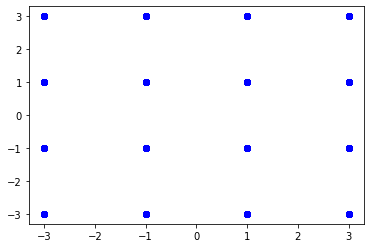

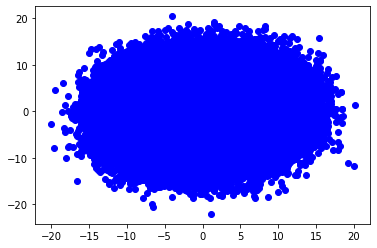

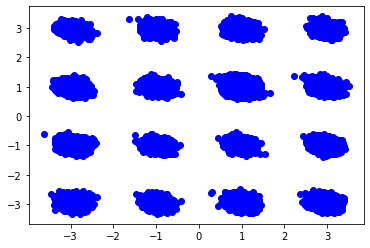

C:\app\tools\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\app\tools\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


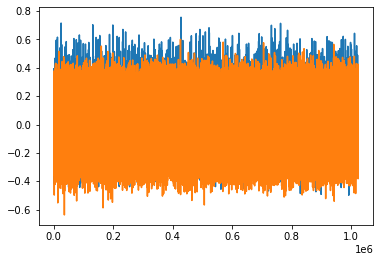

In [4]:
# Test models 

import sys
import numpy as np
import os

os.chdir(r"C:\Users\z642291\Downloads\Jupyter_projects\PAPRnet-master\PARPnet")
from PAPRnet import PAPRnetEncoder, PAPRnetDecoder

N = 855

os.chdir(r"C:\Users\z642291\Downloads\Jupyter_projects\results")

# loading data
x = np.load('OFDM_data_qam_marix.npz')['data']

xval = x[:1000]
xvalrect = np.concatenate( [np.expand_dims(xval.real, 1), np.expand_dims(xval.imag, 1)], axis=1)    # splitting real and imaginary comp

# Encoding
encoder = PAPRnetEncoder(N)
encoder.load_weights('encoder.hdf5')

xenc = encoder.predict(xvalrect, batch_size=N)   # getting encoder output
# print("data : ", xenc)
# print("shape: ", xenc.shape)
xhidd = xenc[:, 0, :] + 1j * xenc[:, 1, :]         # converting to complex values (a+bj)

# adding Gausian Noise
EbNo=3.0
M = 16
k = np.log2(M)
n_ch = 1
R = k/n_ch
noise_std = np.sqrt(1/(2*R*EbNo))
noise_mean = 0
no_errors = 0
noise = noise_std*np.random.randn(xhidd.shape[0],xhidd.shape[1])

xhidd_noise = xhidd + noise

xhidd_noise_rec = np.concatenate( [np.expand_dims(xhidd_noise.real, 1), np.expand_dims(xhidd_noise.imag, 1)], axis=1)

# Decoding
decoder = PAPRnetDecoder(N)
decoder.load_weights('decoder.hdf5')

xdec = decoder.predict(xhidd_noise_rec, batch_size=N)
xest = xdec[:, 0, :] + 1j * xdec[:, 1, :]

## my calculation BER

PS_used, hardDecision = Demapping(xval)
bits_used = PS(PS_used)

PS_est, hardDecision = Demapping(xest)
bits_est = PS(PS_est)

obtained_ber = np.sum(abs(bits_used-bits_est))/len(bits_used)

print("obtained_ber = {}".format(obtained_ber))

# original data before encoder
plt.plot(xval.real, xval.imag, 'bo')
plt.show()

# endcoded data 
plt.plot(xhidd.real, xhidd.imag, 'bo')
plt.show()


# decoded data 
plt.plot(xest.real, xest.imag, 'bo')
plt.show()

# ploting time domain signals
plt.plot(np.fft.ifft(xval,1024).reshape(-1))
plt.plot(np.fft.ifft(xhidd,1024).reshape(-1))
plt.show()

## transmission system ##

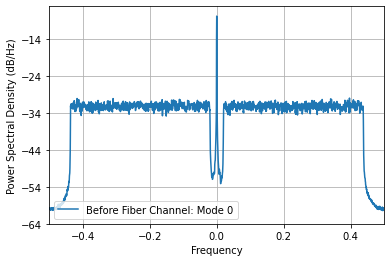

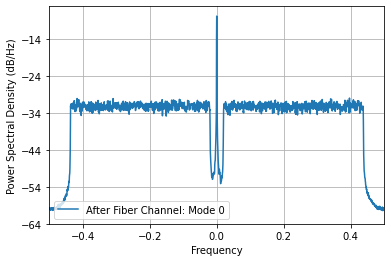

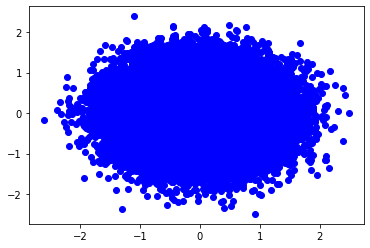

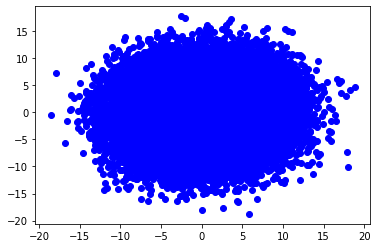

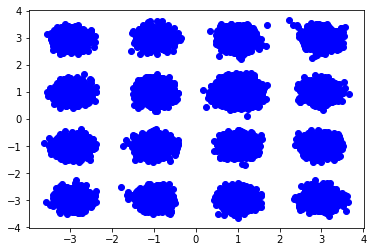

In [5]:
N = 855
# loading data
qam_matrix = np.load('OFDM_data_qam_marix.npz')['data']
xvalrect = np.concatenate( [np.expand_dims(qam_matrix.real, 1), np.expand_dims(qam_matrix.imag, 1)], axis=1)    # splitting real and imaginary comp

# Encoding
encoder = PAPRnetEncoder(N)
encoder.load_weights('encoder.hdf5')

xenc = encoder.predict(xvalrect, batch_size=N)   # getting encoder output
xhidd = xenc[:, 0, :] + 1j * xenc[:, 1, :]         # converting to complex values (a+bj)


# Tx OFDM part 

ofdm_s = OFDM_symbol(xhidd[0:104,:])

ofdm_s_ifft = np.fft.ifft(ofdm_s, 1024)

ofdm_s_ifft_cp = addCP(ofdm_s_ifft)

input_el = ofdm_s_ifft_cp.reshape(-1)

# Channel part
sigCh = opt_domain(input_el)

# Rx OFDM part
ofdm_r_time = sigCh.reshape(104, 1152)
# ofdm_r_time = sigCh.reshape(77376, 1152)

ofdm_r_noCP = removeCP(ofdm_r_time)

ofdm_r_fft = np.fft.fft(ofdm_r_noCP, 1024)

ofdm_r_fft_rfp = rfp(ofdm_r_fft, ofdm_r_noCP)

ofdm_r_qam = OFDM_symbol_Rx(ofdm_r_fft_rfp)

plt.show()
ofdm_r_qam_flat = ofdm_r_qam.reshape(-1)
plt.plot(ofdm_r_qam_flat.real, ofdm_r_qam_flat.imag, 'bo')
plt.show()

# channel correction
ofdm_r_fft_rfp_ce, ofdm_tx_wo_ce = ce(ofdm_r_qam, xhidd[0:104,:], qam_matrix[0:104,:])


ofdm_r_qam_flat_ce = ofdm_r_fft_rfp_ce.reshape(-1)
# ofdm_tx_wo_ce_flat = ofdm_tx_wo_ce.reshape(-1)
plt.plot(ofdm_r_qam_flat_ce.real, ofdm_r_qam_flat_ce.imag, 'bo')
plt.show()

# Autoencoder Decoder
# Decoding
decoder = PAPRnetDecoder(N)
decoder.load_weights('decoder.hdf5')

ofdm_r_fft_rfp_ce_rect = np.concatenate( [np.expand_dims(ofdm_r_fft_rfp_ce.real, 1), np.expand_dims(ofdm_r_fft_rfp_ce.imag, 1)], axis=1)    # splitting real and imaginary comp
xdec = decoder.predict(ofdm_r_fft_rfp_ce_rect, batch_size=N)
xest = xdec[:, 0, :] + 1j * xdec[:, 1, :]
xest_flat = xest.reshape(-1)

plt.plot(xest_flat.real, xest_flat.imag, 'bo')
plt.show()

In [ ]:
# Tx #

In [9]:

N = 855
# loading data
qam_matrix = np.load('OFDM_data_qam_marix.npz')['data']
xvalrect = np.concatenate( [np.expand_dims(qam_matrix.real, 1), np.expand_dims(qam_matrix.imag, 1)], axis=1)    # splitting real and imaginary comp

# Encoding
encoder = PAPRnetEncoder(N)
encoder.load_weights('encoder.hdf5')

xenc = encoder.predict(xvalrect, batch_size=N)   # getting encoder output
xhidd = xenc[:, 0, :] + 1j * xenc[:, 1, :]         # converting to complex values (a+bj)


# Tx OFDM part 

ofdm_s = OFDM_symbol(xhidd[0:104,:])

ofdm_s_ifft = np.fft.ifft(ofdm_s, 1024)

ofdm_s_ifft_cp = addCP(ofdm_s_ifft)

input_el = ofdm_s_ifft_cp.reshape(-1)


# Calculate PAPR
power_peak_NN = np.max(np.square(abs(ofdm_s_ifft_cp)), axis=1)
power_mean_NN = np.mean(np.square(abs(ofdm_s_ifft_cp)), axis=1, dtype=np.float64)

# decibel above average power
PAPR_value_NN = 10* np.log10(power_peak_NN / power_mean_NN)

## Plotting PAPR CCDF

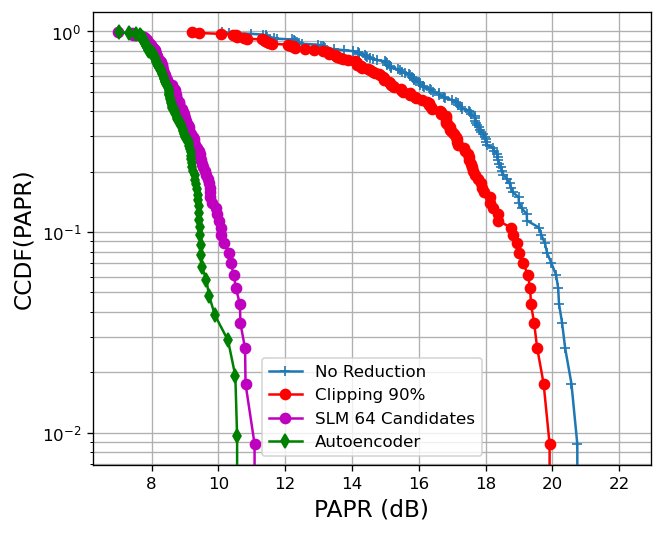

In [10]:
## Plotting PAPR CCDF
from statsmodels.distributions.empirical_distribution import ECDF

PAPR_org = np.load('PAPR_org.npy')
PAPR_clip = np.load('PAPR_clip_90.npy')
PAPR_slm = np.load('PAPR_SLM.npy')


cdf_clip_90 = ECDF(PAPR_clip)
ccdf_clip_90 = 1 - cdf_clip_90.y  # complementary cdf (CCDF)

cdf_slm = ECDF(PAPR_slm)
ccdf_slm = 1 - cdf_slm.y  # complementary cdf (CCDF)

cdf_no = ECDF(PAPR_org)
ccdf_no = 1 - cdf_no.y  # complementary cdf (CCDF)

cdf_nn = ECDF(PAPR_value_NN)
ccdf_nn = 1 - cdf_nn.y  # complementary cdf (CCDF)

#plt.figure(figsize=(7.5, 5))
plt.figure(figsize=(6, 5), dpi= 120, facecolor='w', edgecolor='k');

plt.plot(cdf_no.x, ccdf_no,'-+', label='No Reduction')
plt.plot(cdf_clip_90.x, ccdf_clip_90,'-ro', label='Clipping 90%')
plt.plot(cdf_slm.x, ccdf_slm,'-mo', label='SLM 64 Candidates')

plt.plot(cdf_nn.x, ccdf_nn,'-gd', label='Autoencoder')


plt.yscale('log')

# plt.title('CCDF of OFDM signals with N=1024');
plt.xlabel('PAPR (dB)', fontsize=14);
plt.ylabel('CCDF(PAPR)', fontsize=14);
plt.grid(True, which="both", ls="-")

# plt.legend();
plt.legend(loc='lower center')
plt.show()

# Optical Modulation

Tx Signal


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency', ylabel='Power Spectral Density (dB/Hz)'>)

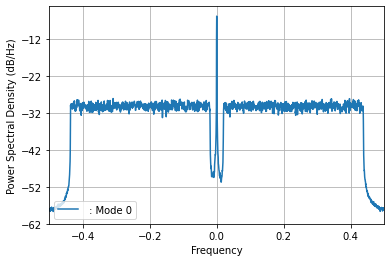

In [7]:
Rs  = 2.5e9         # symbol rate [baud]
SpS = 2           # samples per symbol

################ Optical Modulation #######################################
# transmitter parameters
Ts = 1 / Rs  # symbol period [s]
Fs = 1 / (Ts / SpS)  # sampling frequency [samples/s] --> 20 GSa/s
Fc = 193.1e12  # Hz

# Laser parameters
lw      = 100e3    # laser linewidth in Hz

# IQM parameters
Ai = 1
Vπ = 2
Vb = -Vπ

# # upsampling
# symbolsUp = upsample(symbTx, param.SpS)

# # pulse shaping
# sigTx = firFilter(pulse, symbolsUp)


ϕ_pn_lo = phaseNoise(lw, len(input_el), 1/Fs)
sigLa   = Ai*np.exp(1j*ϕ_pn_lo)

sigTxCh = iqm(sigLa, 0.5 * input_el, Vπ, Vb, Vb)


# Nmodes for Polarization Multiplex and indMode for 2 polarization
# launched power Pch in dB, Pch_dBm in dBm 

LaunchPower = 0 # power per WDM channel [dBm]
Nmodes = 1         # number of signal modes [2 for polarization multiplexed signals]

Pch = 10 ** (LaunchPower / 10) * 1e-3

sigTxCh = (
    np.sqrt(Pch / Nmodes)
    * pnorm(sigTxCh)
)

print ("Tx Signal")
plotPSD(sigTxCh, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])

#### Optical Fiber Channel ###

In [8]:
# Fiber model
linearChannel = True

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 0.3    # 1/(W.km)
paramCh.amp = 'ideal'
paramCh.prgsBar = False   # show progress bar?

if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)

Fs = Rs*SpS
sigCh, paramCh = ssfm(sigTxCh, Fs, paramCh) 


##### Rx - Coherenet Receiver #####

In [9]:
#### Amplifier and OSNR 

sigCh_amp = edfa(sigCh, Fs, G=20, NF=3, Fc=193.1e12)
osnr = [6, 10, 16, 20, 24, 28, 32, 36, 40, 44] # power per WDM channel [dBm]
# osnr = [35]

BER = []
for O in osnr:
    BER_per_ReceivePower = []
    for l in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        
        sigCh_osnr = awgn(sigCh_amp, O, Fs, Rs)

        ######################### Coherent Receiver ####################################
        # photodiodes parameters
        paramPD = parameters()
        paramPD.B = Rs
        paramPD.Fs = Fs    
        paramPD.ideal = True

        # local oscillator (LO) parameters:
        #FO      = 150e6                # frequency offset
        lw      = 100e3                 # linewidth
        Plo_dBm = 10                    # power in dBm
        Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
        ϕ_lo    = 0                     # initial phase in rad 

        # generate LO field
        π       = np.pi
        t       = np.arange(0, len(sigCh_osnr))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh_osnr), Ts)
        sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*t + ϕ_lo + ϕ_pn_lo))


        output_el = coherentReceiver(sigCh_osnr, sigLO, paramPD)  # coherent detection


        ##### DSP Block #####
        # serial to parallel
        ofdm_r_time = output_el.reshape(104, 1152)

        ofdm_r_noCP = removeCP(ofdm_r_time)

        ofdm_r_fft = np.fft.fft(ofdm_r_noCP, 1024)

        ### Phase noise compensation using RFP 
        ofdm_r_fft_rfp = rfp(ofdm_r_fft, ofdm_r_noCP)

        ofdm_r_qam = OFDM_symbol_Rx(ofdm_r_fft_rfp)


        ### channel correction
        ofdm_r_fft_rfp_ce, ofdm_tx_wo_ce = ce(ofdm_r_qam, xhidd[:,:], qam_matrix[0:104,:])
        ofdm_tx_wo_ce_flat = ofdm_tx_wo_ce.reshape(-1)


        # Autoencoder Decoder
        # Decoding
        decoder = PAPRnetDecoder(N)
        decoder.load_weights('decoder.hdf5')

        ofdm_r_fft_rfp_ce_rect = np.concatenate( [np.expand_dims(ofdm_r_fft_rfp_ce.real, 1), np.expand_dims(ofdm_r_fft_rfp_ce.imag, 1)], axis=1)    # splitting real and imaginary comp
        xdec = decoder.predict(ofdm_r_fft_rfp_ce_rect, batch_size=N)
        xest = xdec[:, 0, :] + 1j * xdec[:, 1, :]


        xest_flat = xest.reshape(-1)
        
        
        ### calculate BER
        PS_est_rx, hardDecision_rx = Demapping(xest_flat)
        bits_est_rx = PS(PS_est_rx)
        PS_est_tx, hardDecision_tx = Demapping(ofdm_tx_wo_ce_flat)
        bits_est_tx = PS(PS_est_tx)

        obtained_ber = np.sum(abs(bits_est_tx-bits_est_rx))/len(bits_est_tx)
        
        BER_per_ReceivePower = np.append(BER_per_ReceivePower, obtained_ber)
        if l == 10:
            BER_mean = sum(BER_per_ReceivePower)/len(BER_per_ReceivePower)
            BER = np.append(BER, BER_mean)

### printing results 
print ("OSNR: ", osnr)
print ("Obtained BER: ", BER)


OSNR:  [6, 10, 16, 20, 24, 28, 32, 36, 40, 44]
Obtained BER:  [3.54702729e-01 2.37984284e-01 8.92574318e-02 1.54798164e-02
 1.77875244e-03 4.77176738e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


 ##### Plotting BER for different methods 

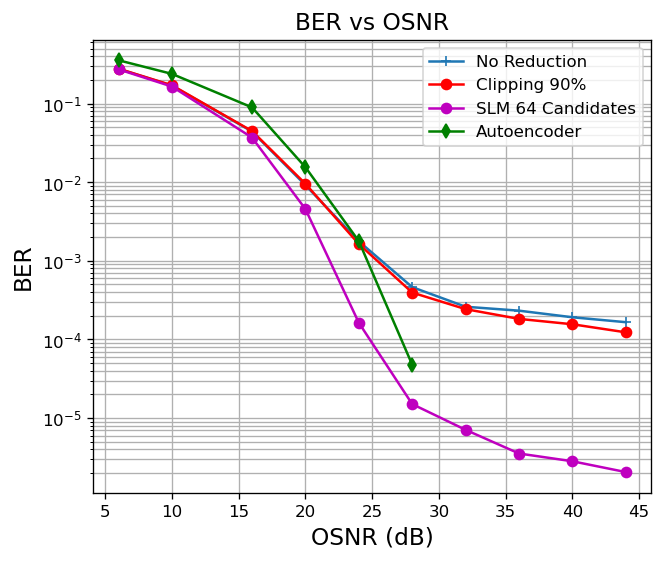

In [3]:
# Plotting BER
OSNR =  [6, 10, 16, 20, 24, 28, 32, 36, 40, 44]
OSNR_nn =  [6, 10, 16, 20, 24, 28, 32]
OSNR_nn1 =  [6, 10, 16, 20, 24, 28]
BER_noComp =  [2.75956938e-01, 1.69033316e-01, 4.39881269e-02, 9.16356548e-03, 1.76944887e-03, 4.62519936e-04, 2.60501506e-04, 2.32146022e-04, 1.91387560e-04, 1.65692008e-04]
BER_clip_90 = [2.77166401e-01, 1.70474039e-01, 4.46517810e-02, 9.53216374e-03, 1.63565479e-03, 3.94293815e-04, 2.42778664e-04, 1.82527025e-04, 1.55945419e-04, 1.23161439e-04]
BER_slm = [2.71853624e-01, 1.64233564e-01, 3.69041290e-02, 4.54899876e-03, 1.63033847e-04, 1.50629098e-05, 7.08842814e-06, 3.54421407e-06, 2.82411417e-06, 2.05816055e-06]
BER_nn = [3.66311322e-01, 2.66930637e-01, 1.01344217e-01, 2.15856481e-02, 1.76149285e-03, 1.47214100e-04, 6.09161793e-06]
BER_nn1 =[3.54702729e-01, 2.37984284e-01, 8.92574318e-02, 1.54798164e-02, 1.77875244e-03, 4.77176738e-05]

fig = plt.figure(figsize=(6, 5), dpi= 120, facecolor='w', edgecolor='k');

plt.plot(OSNR, BER_noComp, '-+', label='No Reduction')
plt.semilogy();
plt.title('BER vs OSNR', fontsize=14);
plt.xlabel('OSNR (dB)', fontsize=14);
plt.ylabel('BER', fontsize=14);
plt.grid(True, which="both", ls="-")

plt.plot(OSNR, BER_clip_90, '-ro', label='Clipping 90%')
plt.plot(OSNR, BER_slm, '-mo', label='SLM 64 Candidates')
plt.plot(OSNR_nn1, BER_nn1, '-gd', label='Autoencoder')
#plt.plot(OSNR_nn1, BER_nn1, '-yd', label='Autoencoder')
plt.legend();
plt.show()

### plotting BER for different Launch Power dBm

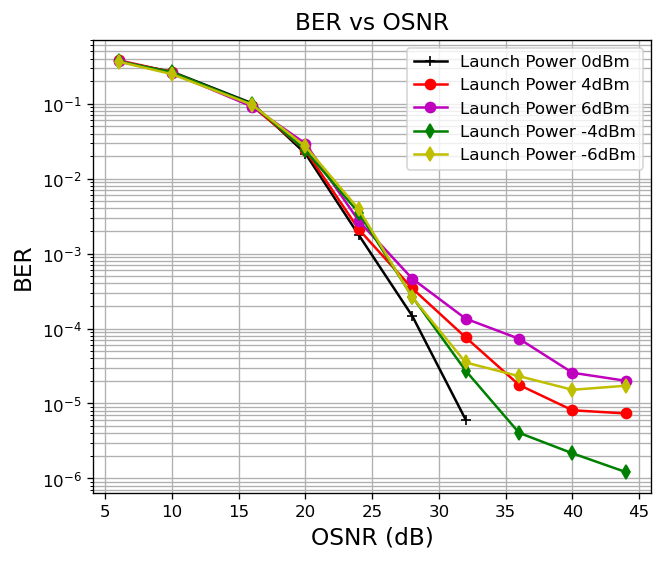

In [11]:
# Plotting BER
OSNR =  [6, 10, 16, 20, 24, 28, 32, 36, 40, 44]
OSNR_0 =  [6, 10, 16, 20, 24, 28, 32]
OSNR_2 =  [6, 10, 16, 20, 24, 28, 32, 36]
BER_0 = [3.66311322e-01, 2.66930637e-01, 1.01344217e-01, 2.15856481e-02, 1.76149285e-03, 1.47214100e-04, 6.09161793e-06]
BER_6 =[3.72590427e-01, 2.58127572e-01, 9.16565140e-02, 2.93974713e-02, 2.71753844e-03, 4.62962963e-04, 1.35369287e-04, 7.30994152e-05, 2.57201646e-05, 2.00738575e-05]
BER_4 = [3.79943010e-01, 2.63276343e-01, 9.31916017e-02, 2.38067197e-02, 2.09890080e-03, 3.43161144e-04, 7.62443145e-05, 1.76846437e-05, 8.12215724e-06,7.35369287e-06]
BER__2 = [3.68733756e-01, 2.62384259e-01, 9.86547677e-02, 2.38537606e-02, 3.48643600e-03, 2.66000650e-04, 2.74122807e-05, 4.06107862e-06, 2.1626966e-06, 1.21526966e-06]
BER__6 = [3.64071637e-01, 2.47670971e-01, 9.68506335e-02, 2.69198749e-02, 3.88645224e-03, 2.61939571e-04, 3.52290448e-05, 2.31481481e-05, 1.52290448e-05, 1.72595841e-05]

fig = plt.figure(figsize=(6, 5), dpi= 120, facecolor='w', edgecolor='k');

plt.plot(OSNR_0, BER_0, '-k+', label='Launch Power 0dBm')
plt.semilogy();
plt.title('BER vs OSNR', fontsize=14);
plt.xlabel('OSNR (dB)', fontsize=14);
plt.ylabel('BER', fontsize=14);
plt.grid(True, which="both", ls="-")

plt.plot(OSNR, BER_4, '-ro', label='Launch Power 4dBm')
plt.plot(OSNR, BER_6, '-mo', label='Launch Power 6dBm')
plt.plot(OSNR, BER__2, '-gd', label='Launch Power -4dBm')
plt.plot(OSNR, BER__6, '-yd', label='Launch Power -6dBm')
plt.legend();
plt.show()

### Plotting BER for different trained Gaussian Noise EbNo

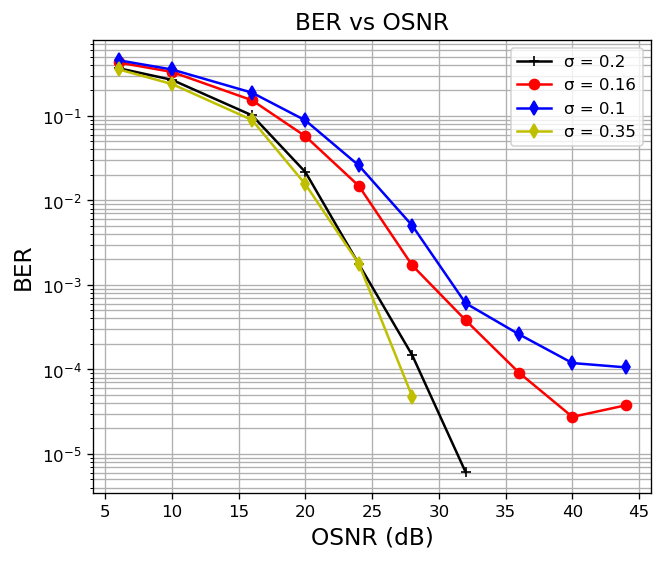

In [16]:
# Plotting BER
# Noise levels corresponding to using gaussian noise standard deviations of were considered.

OSNR =  [6, 10, 16, 20, 24, 28, 32, 36, 40, 44]
OSNR_0 =  [6, 10, 16, 20, 24, 28, 32]
OSNR_1 =  [6, 10, 16, 20, 24, 28]
BER_5dB = [3.66311322e-01, 2.66930637e-01, 1.01344217e-01, 2.15856481e-02, 1.76149285e-03, 1.47214100e-04, 6.09161793e-06]
BER_7dB = [4.27931083e-01, 3.30641853e-01, 1.52902656e-01, 5.73211095e-02, 1.48280133e-02, 1.70260721e-03, 3.81741391e-04, 9.13742690e-05, 2.74122807e-05, 3.75649773e-05]
BER_10dB = [4.54668210e-01, 3.53546337e-01, 1.88053322e-01, 8.82756660e-02, 2.58528265e-02, 5.03167641e-03, 6.06115984e-04, 2.59909032e-04, 1.18786550e-04, 1.05588044e-04]
BER_0dB =[3.54702729e-01, 2.37984284e-01, 8.92574318e-02, 1.54798164e-02, 1.77875244e-03, 4.77176738e-05]

fig = plt.figure(figsize=(6, 5), dpi= 120, facecolor='w', edgecolor='k');

plt.plot(OSNR_0, BER_5dB, '-k+', label='σ = 0.2')
plt.semilogy();
plt.title('BER vs OSNR', fontsize=14);
plt.xlabel('OSNR (dB)', fontsize=14);
plt.ylabel('BER', fontsize=14);
plt.grid(True, which="both", ls="-")

plt.plot(OSNR, BER_7dB, '-ro', label='σ = 0.16')
plt.plot(OSNR, BER_10dB, '-bd', label='σ = 0.1')
plt.plot(OSNR_1, BER_0dB, '-yd', label='σ = 0.35')
plt.legend();
plt.show()

In [12]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.4
scipy==1.9.3
pip==23.3.1
tensorflow==2.10.0
mpld3==0.5.9
